In [1]:
# Primero cargo los datos
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns 

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble      import GradientBoostingClassifier
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn import utils

import lightgbm as lgb


In [2]:
# Read the data
X_train_full = pd.read_csv('./data/train.csv', index_col='Id')
X_test_full = pd.read_csv('./data/test.csv', index_col='Id')

In [3]:
# Veo de que va 
X_train_full.shape

(160435, 13)

In [4]:
X_train_full.head()

,Marca,Modelo,Tiempo,Provincia,Localidad,Año,Kms,Cambio,Cv,Combust,Puertas,Vendedor,Precio
Id,,,,,,,,,,,,,
0,OPEL,VECTRA,33 días,la_rioja,Arnedo,2005.0,200000.0,manual,120.0,diesel,5.0,Profesional,2200
1,NISSAN,PRIMERA,43 horas,aragon,Teruel,2008.0,400000.0,manual,100.0,diesel,4.0,Particular,3500
2,RENAULT,CLIO BUSINESS DCI 75 ECO2,14 horas,sevilla,Camas,2014.0,53565.0,manual,75.0,diesel,5.0,Profesional,8200
3,MERCEDES-BENZ,CLASE CLS,1 hora,burgos,Burgos,2007.0,215000.0,automat,224.0,diesel,4.0,Particular,12500
4,RENAULT,CAPTUR LIFE ENERGY DCI 90 ECO2 EURO 6,45 días,caceres,Caceres,2016.0,119945.0,manual,90.0,diesel,5.0,Profesional,9900


In [5]:
X_test_full.head()

,Marca,Modelo,Tiempo,Provincia,Localidad,Año,Kms,Cambio,Cv,Combust,Puertas,Vendedor
Id,,,,,,,,,,,,
0,ALFA ROMEO,GIULIETTA,11 horas,jaen,NaN,2013.0,95000.0,manual,105.0,diesel,5.0,Particular
1,CITROEN,XSARA PICASSO 2. 0 HDI EXCLUSIVE,570 días,lugo,Begonte,2006.0,240000.0,manual,90.0,diesel,5.0,Profesional
2,BMW,SERIE 3,9 días,asturias,Pola De Laviana,NaN,178000.0,manual,150.0,diesel,5.0,Particular
3,VOLKSWAGEN,PASSAT,12 horas,ourense,Ourense / Orense,2002.0,160000.0,manual,100.0,diesel,5.0,Profesional
4,HYUNDAI,COUPÉ,43 días,castellon,Segorbe,2002.0,170000.0,manual,146.0,gasolina,3.0,Particular


In [6]:
X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160435 entries, 0 to 160434
Data columns (total 13 columns):
Marca        160435 non-null object
Modelo       160435 non-null object
Tiempo       160435 non-null object
Provincia    160435 non-null object
Localidad    145457 non-null object
Año          157104 non-null float64
Kms          150278 non-null float64
Cambio       160375 non-null object
Cv           145378 non-null float64
Combust      160413 non-null object
Puertas      160198 non-null float64
Vendedor     160409 non-null object
Precio       160435 non-null int64
dtypes: float64(4), int64(1), object(8)
memory usage: 17.1+ MB


In [7]:
X_train_full.describe()

,Año,Kms,Cv,Puertas,Precio
count,157104.000000,1.502780e+05,145378.000000,160198.000000,1.604350e+05
mean,2009.094262,1.503070e+05,141.379143,4.495468,1.098547e+04
std,7.497642,2.325317e+05,431.262674,0.880793,5.549184e+04
min,1908.000000,1.000000e+00,1.000000,2.000000,2.500000e+01
25%,2004.000000,7.400000e+04,102.000000,4.000000,2.950000e+03
50%,2009.000000,1.400000e+05,125.000000,5.000000,7.000000e+03
75%,2015.000000,2.020000e+05,150.000000,5.000000,1.449000e+04
max,2020.000000,1.677722e+07,65535.000000,5.000000,1.180000e+07


In [8]:
# Esto no funciona porque es muy gordo el dataset
#from pandas_profiling import ProfileReport
#profile = ProfileReport(X_train_full)
#profile.to_file(output_file="./data/profile-X_train_full.html")

In [9]:
# Remove rows with missing target, separate target from predictors
# Me voy a cargar la localidad que no hace más que molestar
X_train_full.drop(['Localidad'], axis=1, inplace =True)
X_test_full.drop(['Localidad'], axis=1, inplace =True)

In [10]:
# Veo columnas numéricas y categóricas. El precio no entra en numérico porque es int64
numerical_columns = [col for col in X_train_full.columns if X_train_full[col].dtype == 'float64']
categorical_columns = [col for col in X_train_full.columns if X_train_full[col].dtype == 'object']

In [11]:
print(numerical_columns)
print(categorical_columns)

['Año', 'Kms', 'Cv', 'Puertas']
['Marca', 'Modelo', 'Tiempo', 'Provincia', 'Cambio', 'Combust', 'Vendedor']


In [12]:
# veo el número de columnas numéricas con nulos y cuantos tienen
for column in numerical_columns:
    numero_ceros = X_train_full[column].isnull().sum()
    if numero_ceros > 0:
        print("Columna ", column, "tiene ", numero_ceros, "ceros")

Columna  Año tiene  3331 ceros
Columna  Kms tiene  10157 ceros
Columna  Cv tiene  15057 ceros
Columna  Puertas tiene  237 ceros


In [13]:
# veo el número de columnas categóricas con nulos y cuantos tienen
for column in categorical_columns:
    numero_ceros = X_train_full[column].isnull().sum()
    if numero_ceros > 0:
        print("Columna ", column, "tiene ", numero_ceros, "ceros")

Columna  Cambio tiene  60 ceros
Columna  Combust tiene  22 ceros
Columna  Vendedor tiene  26 ceros


In [14]:
# Las columnas con 0 son poquísimas en las categóricas. Me las voy a cargar
X_train_full.dropna(subset=['Cambio', 'Combust', 'Vendedor'], inplace = True)

In [15]:
# Veo las columnas categóricas en los test y me las cargo
categorial_columns_test = [col for col in X_train_full.columns if X_train_full[col].dtype == 'object']

In [16]:
print(categorial_columns_test)

['Marca', 'Modelo', 'Tiempo', 'Provincia', 'Cambio', 'Combust', 'Vendedor']


In [17]:
# veo el número de ceros en los test
for column in categorial_columns_test:
    numero_ceros = X_test_full[column].isnull().sum()
    if numero_ceros > 0:
        print("Columna ", column, "tiene ", numero_ceros, "ceros")

Columna  Cambio tiene  24 ceros
Columna  Combust tiene  7 ceros
Columna  Vendedor tiene  10 ceros


In [18]:
# Las columnas con 0 son poquísimas en las categóricas. Me las voy a cargar
X_train_full.dropna(subset=['Cambio', 'Combust', 'Vendedor'], inplace = True)

In [19]:
# Voy a probar con un sample
X_train_sample = X_train_full.sample(100)
X_train_sample.dropna(axis=0, subset=['Precio'], inplace=True)

In [20]:
y_sample = X_train_sample.Precio
X_train_sample.drop(['Precio'], axis=1, inplace=True)

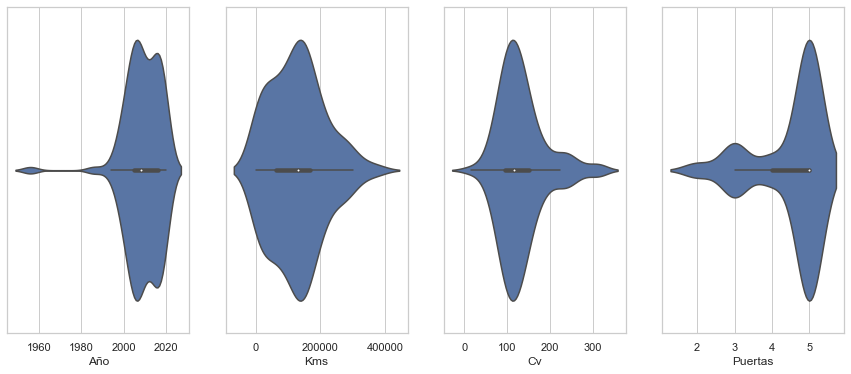

In [21]:
sns.set(style="whitegrid")
f, ax = plt.subplots(1, 4, sharey = True, figsize=(15,6))

contador = 0
for column in numerical_columns:
    sns.violinplot(x=X_train_sample[column], ax=ax[contador])
    contador = contador +1

In [22]:
# veo el número de valores en las columnas categóricas
for column in categorical_columns:
    valores_unicos = X_train_sample[column].nunique()
    print("Columna ", column, "tiene ", valores_unicos, "valores únicos")

Columna  Marca tiene  28 valores únicos
Columna  Modelo tiene  98 valores únicos
Columna  Tiempo tiene  58 valores únicos
Columna  Provincia tiene  38 valores únicos
Columna  Cambio tiene  2 valores únicos
Columna  Combust tiene  3 valores únicos
Columna  Vendedor tiene  2 valores únicos


In [23]:
# Numéricos los cambio por la media
# Cambio, combustible y vendedor onehot_code

In [24]:
# Los numéricos los sustituyo por la media
numerical_transformer = SimpleImputer(strategy='mean')

In [25]:
# Los categóricos un labelencoder
le = LabelEncoder()
for col in categorical_columns:
    print(col)
    X_train_sample.loc[(X_train_sample[col].notnull()),col] = le.fit_transform(X_train_sample[(X_train_sample[col].notnull())][col])

Marca
Modelo
Tiempo
Provincia
Cambio
Combust
Vendedor


In [26]:
X_train_sample.head()

,Marca,Modelo,Tiempo,Provincia,Año,Kms,Cambio,Cv,Combust,Puertas,Vendedor
Id,,,,,,,,,,,
14212,22,60,53,5,2018.0,21686.0,1,110.0,1,5.0,1
157596,12,91,11,14,2020.0,1.0,1,110.0,1,5.0,1
116688,27,81,14,37,2008.0,205000.0,1,136.0,0,4.0,1
151905,12,88,29,3,2011.0,130182.0,1,115.0,0,5.0,1
121197,22,16,18,20,2017.0,23800.0,1,115.0,0,5.0,1


In [27]:
# Los categóricos los sustituyo por el valor más frecuente y luego le hago un onehot encoder
#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='most_frequent')),
#    ('onehot', OneHotEncoder(handle_unknown='ignore'))
#])

In [28]:
# Defino el preprocesador para ambos tipos de columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns)
        #,('cat', categorical_transformer, categorical_columns)
    ])

In [29]:
# Selecciono el modelo
model = lgb.LGBMRegressor()
#model = XGBClassifier(n_estimators=250)

In [30]:
# Hago el pipelie con el preprocesado y el modelo
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

In [31]:
# Divido el modelo para entrenar y testear
X_train, X_val, y_train, y_val = train_test_split(X_train_sample, y_sample, random_state = 0)

In [32]:
X_train.head()

,Marca,Modelo,Tiempo,Provincia,Año,Kms,Cambio,Cv,Combust,Puertas,Vendedor
Id,,,,,,,,,,,
137519,23,39,10,6,2004.0,132000.0,1,75.0,1,5.0,0
28219,1,7,21,7,2014.0,54387.0,1,86.0,1,5.0,1
95804,26,93,56,31,2015.0,127000.0,1,110.0,0,5.0,1
48083,16,30,57,24,2003.0,201970.0,0,245.0,1,4.0,1
151365,20,92,40,34,2012.0,113000.0,1,92.0,0,5.0,1


In [33]:
X_val.head()

,Marca,Modelo,Tiempo,Provincia,Año,Kms,Cambio,Cv,Combust,Puertas,Vendedor
Id,,,,,,,,,,,
122474,7,83,22,29,2008.0,155000.0,1,120.0,0,5.0,1
131676,10,52,16,5,2016.0,145000.0,1,115.0,0,5.0,1
116688,27,81,14,37,2008.0,205000.0,1,136.0,0,4.0,1
111707,22,62,31,11,2002.0,190000.0,1,150.0,0,5.0,0
23319,17,15,16,2,2013.0,124786.0,1,116.0,0,5.0,1


In [34]:
y_train.head()

Id
137519     2200
28219     11500
95804     14500
48083      2450
151365     6000
Name: Precio, dtype: int64

In [35]:
y_val.head()

Id
122474     5500
131676    13500
116688     4690
111707     1500
23319     10800
Name: Precio, dtype: int64

In [36]:
print(np.log1p(y_train))

Id
137519     7.696667
28219      9.350189
95804      9.581973
48083      7.804251
151365     8.699681
            ...    
62979     10.184938
153452     8.412055
54607      9.148571
36971      7.937732
68620     10.460271
Name: Precio, Length: 75, dtype: float64


In [37]:
# Me da un error al ajustar porque parece que el y_train es un continuo. 
# Voy a convertirlo con un label encoder
#lab_enc = preprocessing.LabelEncoder()
y_train_log = np.log1p(y_train)
#y_train_log_encoded = lab_enc.fit_transform(y_train_log)
#print(utils.multiclass.type_of_target(y_train_log_encode))
print(utils.multiclass.type_of_target(y_train_log))
print(utils.multiclass.type_of_target(y_train))

continuous
multiclass


In [38]:
print(y_train)

Id
137519     2200
28219     11500
95804     14500
48083      2450
151365     6000
          ...  
62979     26500
153452     4500
54607      9400
36971      2800
68620     34900
Name: Precio, Length: 75, dtype: int64


In [39]:
# Ya puedo entrenar el modelo
my_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='mean',
                                                                verbose=0),
                                                  ['Año', 'Kms', 'Cv',
                                                   'Puertas'])],
                                   verbose=False)),
                ('model',
        

In [40]:
# Preprocessing of validation data, get predictions
# para calcular la predicción he de hacer la operación inversa al logaritmo, que es el exponene
#preds = np.expm1(my_pipeline.predict(X_val))
preds = np.abs(my_pipeline.predict(X_val))

In [41]:
print(preds)

[ 6009.77303942 11131.512944    4380.88035866  6043.8339095
 10971.79614169 16225.00484669  2931.18570042  3322.8749476
 17969.12392954  8179.1752828   4515.12102423 24881.18427663
  9354.69107585  2464.52806729 14899.13776328 24881.18427663
  1484.92217689 24881.18427663 20174.75123148 24881.18427663
  6790.91574951 14304.84353769  7252.39257426 11786.4895542
 14304.84353769]


In [42]:
# Muestro el valor de la métrica de la predicción
print(np.sqrt(mean_squared_log_error( y_val, preds )))

0.7195174159731964


In [43]:
# Ahora a los de test les tengo que hacer el mismo tratamiento
# Los categóricos un labelencoder
le = LabelEncoder()
for col in categorical_columns:
    print(col)
    X_test_full.loc[(X_test_full[col].notnull()),col] = le.fit_transform(X_test_full[(X_test_full[col].notnull())][col])

Marca
Modelo
Tiempo
Provincia
Cambio
Combust
Vendedor


In [45]:
X_test_full['Precio'] = np.abs(my_pipeline.predict(X_test_full))

In [46]:
X_test_full.head()

,Marca,Modelo,Tiempo,Provincia,Año,Kms,Cambio,Cv,Combust,Puertas,Vendedor,Precio
Id,,,,,,,,,,,,
0,1,12606,22,26,2013.0,95000.0,1,105.0,1,5.0,0,10615.361016
1,12,24943,539,32,2006.0,240000.0,1,90.0,1,5.0,1,949.418825
2,8,21679,710,5,NaN,178000.0,1,150.0,1,5.0,0,11602.262080
3,68,18696,35,38,2002.0,160000.0,1,100.0,1,5.0,1,2464.528067
4,26,10343,417,15,2002.0,170000.0,1,146.0,3,3.0,0,6043.833910


In [47]:
submission = X_test_full["Precio"]

In [49]:
submission.to_csv("./data/LGBMRegressor.csv", index=True, header=True)